In [1]:
load(url("https://github.com/mgimond/Spatial/raw/main/Data/moransI.RData"))

In [2]:
s1

Loading required package: sp

Warning message in wkt(x):
“CRS object has no comment”
Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



An object of class "SpatialPolygonsDataFrame"
Slot "data":
           NAME Income   NoSchool  NoSchoolSE IncomeSE
0     Aroostook  21024 0.01338720 0.001406960  250.909
1      Somerset  21025 0.00521153 0.001150020  390.909
2   Piscataquis  21292 0.00633830 0.002128960  724.242
3     Penobscot  23307 0.00684534 0.001025450  242.424
4    Washington  20015 0.00478188 0.000966036  327.273
5      Franklin  21744 0.00508507 0.001641740  530.909
6        Oxford  21885 0.00700822 0.001318160  536.970
7         Waldo  23020 0.00498141 0.000918837  450.909
8      Kennebec  25652 0.00570358 0.000917087  360.000
9  Androscoggin  24268 0.00830953 0.001178660  460.606
10      Hancock  28071 0.00238996 0.000784584  585.455
11         Knox  27141 0.00652269 0.001863920  684.849
12      Lincoln  27839 0.00278315 0.001030800  571.515
13   Cumberland  32549 0.00494917 0.000683236  346.061
14    Sagadahoc  28122 0.00285524 0.000900782  544.849
15         York  28496 0.00529228 0.000737195  332.121

Slot 

In [8]:
install.packages("spdep")
library(spdep)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [9]:
nb = poly2nb(s1, queen = TRUE)
nb

Neighbour list object:
Number of regions: 16 
Number of nonzero links: 66 
Percentage nonzero weights: 25.78125 
Average number of links: 4.125 

In [14]:
nb[[15]] # polygon 15 has 4 neighbors
s1$NAME[[15]] # polygon 15's name is Sagadahoc
s1$NAME[nb[[15]]] # it's 4 neighbors are Kennebc, Androscoggin, Lincoln, Cumberland

[1]  9 10 13 14

[1] Sagadahoc
16 Levels: Androscoggin Aroostook Cumberland Franklin Hancock Kennebec ... York

[1] Kennebec     Androscoggin Lincoln      Cumberland  
16 Levels: Androscoggin Aroostook Cumberland Franklin Hancock Kennebec ... York

In [24]:
lw = nb2listw(nb, style = "W", zero.policy = TRUE)
# weights from polygon 15's 4 neighbors
lw$weights[[1]]

[1] 0.25 0.25 0.25 0.25

In [25]:
Inc.lag <- lag.listw(lw, s1$Income)
head(Inc.lag)

[1] 21409.75 22673.17 21785.33 22407.83 24134.00 23207.50

In [26]:
# hesitant to use linear regression but ok
M <- lm(Inc.lag ~ s1$Income)

In [30]:
# computing a pseduo p value - hard
n <- 599L   # Define the number of simulations
I.r <- vector(length=n)  # Create an empty vector

for (i in 1:n){
# setting seed for reproducibility
  set.seed(7)
  # Randomly shuffle income values
  x <- sample(s1$Income, replace=FALSE)
  # Compute new set of lagged values
  x.lag <- lag.listw(lw, x)
  # Compute the regression slope and store its value
  M.r    <- lm(x.lag ~ x)
  I.r[i] <- coef(M.r)[2]
}

N.greater <- sum(coef(M)[2] > I.r)
p <- min(N.greater + 1, n + 1 - N.greater) / (n + 1)
p

[1] 0.025

In [31]:
# computing a pseduo p value - easy
MC <- moran.mc(s1$Income, lw, nsim=599)

# View results (including p-value)
MC


	Monte-Carlo simulation of Moran I

data:  s1$Income 
weights: lw  
number of simulations + 1: 600 

statistic = 0.28281, observed rank = 586, p-value = 0.02333
alternative hypothesis: greater


In [45]:
setwd('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1009. NC ENVRIOSCAN/P1009.3. Analyses/P1009.3.6. Mapping')
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1009. NC ENVRIOSCAN/P1009.3. Analyses/P1009.3.6. Mapping/Output')
cur_date = "030923"

library(readxl)
library(tidyverse)
library(reshape2)
library(sf)
library(tigris)
# library(cowplot)
# library(rcartocolor)
# library(RColorBrewer)
# library(MetBrewer)

# reading in files
whp_df = data.frame(read_excel("Input/Imputed_Wildfire_Hazard_030923.xlsx"))

In [46]:
head(whp_df)

,GEO_ID,FIPS,County,Census_Tract,Avg_ACRES,Wildfire_Hazard_Potential_Mean
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177
2,14000US37141920401,37141920401,Pender,9204.01,596842.6,715.5177
3,14000US37141920402,37141920402,Pender,9204.02,596842.6,715.5177
4,14000US37141920403,37141920403,Pender,9204.0300000000007,596842.6,715.5177
5,14000US37141920601,37141920601,Pender,9206.01,596842.6,715.5177
6,14000US37141990100,37141990100,Pender,9901,596842.6,715.5177


In [47]:
# download shapefile from the tigris (census package)
nc_census_tract_shapefile = tracts(state = 37, year = 2010) %>%
    rename(FIPS = GEOID10)

head(nc_census_tract_shapefile)

,STATEFP10,COUNTYFP10,TRACTCE10,FIPS,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,COUNTYFP,STATEFP,geometry
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<MULTIPOLYGON [°]>
1,37,153,970100,37153970100,9701,Census Tract 9701,G5020,S,246281647,2106825,+35.0503203,-079.6180454,153,37,MULTIPOLYGON (((-79.56729 3...
2,37,153,970200,37153970200,9702,Census Tract 9702,G5020,S,457736198,7835811,+35.0967892,-079.8225512,153,37,MULTIPOLYGON (((-79.71753 3...
3,37,153,970800,37153970800,9708,Census Tract 9708,G5020,S,139358521,2752112,+34.8508484,-079.8201950,153,37,MULTIPOLYGON (((-79.76773 3...
4,37,153,970900,37153970900,9709,Census Tract 9709,G5020,S,23311020,78240,+34.8785679,-079.7346295,153,37,MULTIPOLYGON (((-79.76773 3...
5,37,153,971000,37153971000,9710,Census Tract 9710,G5020,S,49233222,188190,+34.9395795,-079.6628977,153,37,MULTIPOLYGON (((-79.69038 3...
6,37,153,971100,37153971100,9711,Census Tract 9711,G5020,S,161136716,948938,+34.8751742,-079.6567146,153,37,MULTIPOLYGON (((-79.5684 34...


In [49]:
# first changing data type of some of the columns
whp_df$FIPS = as.character(whp_df$FIPS)

# combining data
whp_spatial_df = full_join(whp_df, nc_census_tract_shapefile)
whp_spatial_df$Wildfire_Hazard_Potential_Quintile_Number = as.character(whp_spatial_df$Wildfire_Hazard_Potential_Quintile_Number)

head(whp_spatial_df)

Joining, by = "FIPS"


,GEO_ID,FIPS,County,Census_Tract,Avg_ACRES,Wildfire_Hazard_Potential_Mean,STATEFP10,COUNTYFP10,TRACTCE10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,COUNTYFP,STATEFP,geometry
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<MULTIPOLYGON [°]>
1,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177,37,141,920201,9202.01,Census Tract 9202.01,G5020,S,21147417,44942,+34.4018480,-077.6218025,141,37,MULTIPOLYGON (((-77.66061 3...
2,14000US37141920401,37141920401,Pender,9204.01,596842.6,715.5177,37,141,920401,9204.01,Census Tract 9204.01,G5020,S,75755882,15209,+34.5055979,-077.9462191,141,37,MULTIPOLYGON (((-77.94007 3...
3,14000US37141920402,37141920402,Pender,9204.02,596842.6,715.5177,37,141,920402,9204.02,Census Tract 9204.02,G5020,S,65209545,12064,+34.5702392,-077.9912005,141,37,MULTIPOLYGON (((-77.92338 3...
4,14000US37141920403,37141920403,Pender,9204.0300000000007,596842.6,715.5177,37,141,920403,9204.03,Census Tract 9204.03,G5020,S,106488713,1076000,+34.5493899,-077.8690183,141,37,MULTIPOLYGON (((-77.83308 3...
5,14000US37141920601,37141920601,Pender,9206.01,596842.6,715.5177,37,141,920601,9206.01,Census Tract 9206.01,G5020,S,103459422,348628,+34.4486577,-077.9634232,141,37,MULTIPOLYGON (((-77.94027 3...
6,14000US37141990100,37141990100,Pender,9901,596842.6,715.5177,37,141,990100,9901,Census Tract 9901,G5020,S,0,133298842,+34.3492469,-077.6031266,141,37,MULTIPOLYGON (((-77.67696 3...


In [50]:
# need to transform this into a sf object 
whp_spatial_sf = st_as_sf(whp_spatial_df)
head(whp_spatial_sf)

,GEO_ID,FIPS,County,Census_Tract,Avg_ACRES,Wildfire_Hazard_Potential_Mean,STATEFP10,COUNTYFP10,TRACTCE10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,COUNTYFP,STATEFP,geometry
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<MULTIPOLYGON [°]>
1,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177,37,141,920201,9202.01,Census Tract 9202.01,G5020,S,21147417,44942,+34.4018480,-077.6218025,141,37,MULTIPOLYGON (((-77.66061 3...
2,14000US37141920401,37141920401,Pender,9204.01,596842.6,715.5177,37,141,920401,9204.01,Census Tract 9204.01,G5020,S,75755882,15209,+34.5055979,-077.9462191,141,37,MULTIPOLYGON (((-77.94007 3...
3,14000US37141920402,37141920402,Pender,9204.02,596842.6,715.5177,37,141,920402,9204.02,Census Tract 9204.02,G5020,S,65209545,12064,+34.5702392,-077.9912005,141,37,MULTIPOLYGON (((-77.92338 3...
4,14000US37141920403,37141920403,Pender,9204.0300000000007,596842.6,715.5177,37,141,920403,9204.03,Census Tract 9204.03,G5020,S,106488713,1076000,+34.5493899,-077.8690183,141,37,MULTIPOLYGON (((-77.83308 3...
5,14000US37141920601,37141920601,Pender,9206.01,596842.6,715.5177,37,141,920601,9206.01,Census Tract 9206.01,G5020,S,103459422,348628,+34.4486577,-077.9634232,141,37,MULTIPOLYGON (((-77.94027 3...
6,14000US37141990100,37141990100,Pender,9901,596842.6,715.5177,37,141,990100,9901,Census Tract 9901,G5020,S,0,133298842,+34.3492469,-077.6031266,141,37,MULTIPOLYGON (((-77.67696 3...


In [73]:
library(tmap)

In [63]:
tm_shape(whp_spatial_sf) + 
  tm_fill("Wildfire_Hazard_Potential_Mean",
          palette = "Reds", 
          style = "quantile", 
          title = "% with a Qualification") +
  tm_borders(alpha=.4)  

ERROR: Error in tm_shape(whp_spatial_sf): could not find function "tm_shape"


In [52]:
neighbors = poly2nb(whp_spatial_sf)
neighbors

Neighbour list object:
Number of regions: 2195 
Number of nonzero links: 13612 
Percentage nonzero weights: 0.2825224 
Average number of links: 6.201367 

In [62]:
neighbors[[1]] # polygon 1 has 6 neighbors
whp_spatial_sf$GEO_ID[[1]] # geo id for this region (polygon)
whp_spatial_sf$GEO_ID[neighbors[[1]]] # geo ids for this region's neighbors

[1]  47  48  49 137 138 139

[1] "14000US37141920201"

[1] "14000US37141920102" "14000US37141920103" "14000US37141920204"
[4] "14000US37141920101" "14000US37141920202" "14000US37141920203"

In [66]:
# weight matrix
listw = nb2listw(neighbors)
listw

Characteristics of weights list object:
Neighbour list object:
Number of regions: 2195 
Number of nonzero links: 13612 
Percentage nonzero weights: 0.2825224 
Average number of links: 6.201367 

Weights style: W 
Weights constants summary:
     n      nn   S0       S1       S2
W 2195 4818025 2195 736.9648 9000.876

In [71]:
# global moran test
global_moran = moran.test(whp_spatial_df$Wildfire_Hazard_Potential_Mean, listw)
global_moran

# our p value is sig and our moran statistic shows positive autocorrelated in NC meaning that the data does 
# spatially cluster
# p value only
global_moran$p.value


	Moran I test under randomisation

data:  whp_spatial_df$Wildfire_Hazard_Potential_Mean  
weights: listw    

Moran I statistic standard deviate = 74.765, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.9220168766     -0.0004557885      0.0001522343 


[1] 0

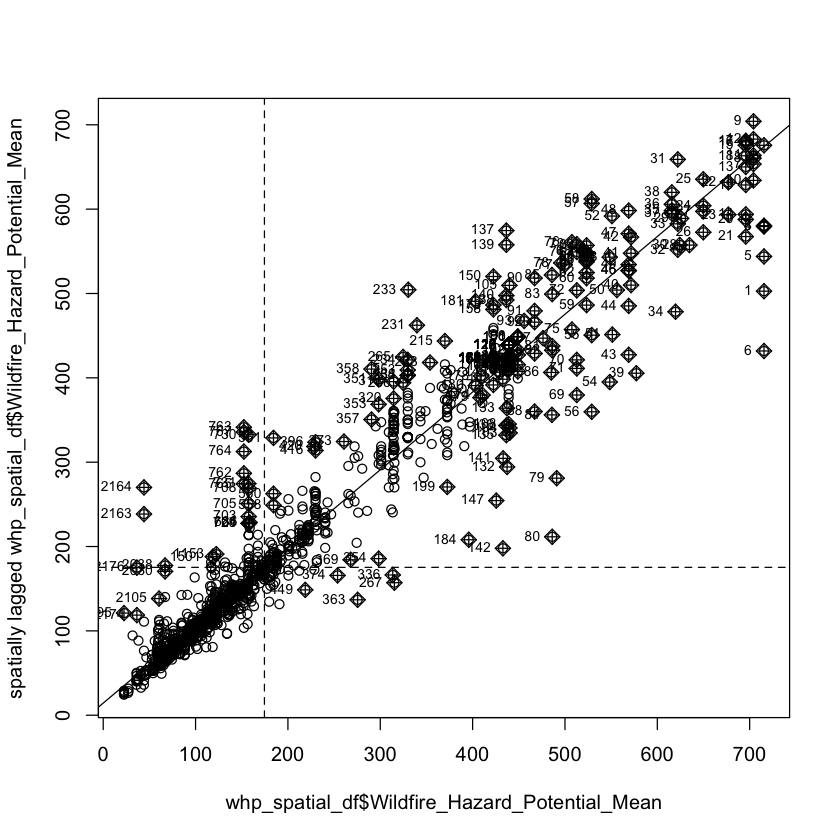

In [72]:
#not sure what exactly this means
moran.plot(whp_spatial_df$Wildfire_Hazard_Potential_Mean, listw = nb2listw(neighbors, style = "W"))

In [76]:
# local moran
local <- localmoran(x = whp_spatial_df$Wildfire_Hazard_Potential_Mean, listw = nb2listw(neighbors, style = "W"))
head(local)

,Ii,E.Ii,Var.Ii,Z.Ii,Pr(z != E(Ii))
1,11.357551,-0.008532566,3.087806,6.468236,9.915387e-11
2,17.342329,-0.008532566,4.635943,8.058459,7.726244e-16
3,14.009781,-0.008532566,4.635943,6.510686,7.480857e-11
4,14.044451,-0.008532566,3.087806,7.997303,1.271745e-15
5,12.782130,-0.008532566,3.087806,7.278938,3.364577e-13
6,8.903252,-0.008532566,3.087806,5.071538,3.946143e-07


In [77]:
quadrant <- vector(mode="numeric",length=nrow(local))

# centers the variable of interest around its mean
m.qualification <- whp_spatial_df$Wildfire_Hazard_Potential_Mean - mean(whp_spatial_df$Wildfire_Hazard_Potential_Mean)     

# centers the local Moran's around the mean
m.local <- local[,1] - mean(local[,1])    

# significance threshold
signif <- 0.05 

# builds a data quadrant
quadrant[m.qualification >0 & m.local>0] <- 4  
quadrant[m.qualification <0 & m.local<0] <- 1      
quadrant[m.qualification <0 & m.local>0] <- 2
quadrant[m.qualification >0 & m.local<0] <- 3
quadrant[local[,5]>signif] <- 0   

In [78]:
brks <- c(0,1,2,3,4)
colors <- c("white","blue",rgb(0,0,1,alpha=0.4),rgb(1,0,0,alpha=0.4),"red")
plot(whp_spatial_df,border="lightgray",col=colors[findInterval(quadrant,brks,all.inside=FALSE)])
box()
legend("bottomleft", legend = c("insignificant","low-low","low-high","high-low","high-high"),
       fill=colors,bty="n")

ERROR: Error in data.matrix(x): 'list' object cannot be coerced to type 'double'
